In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def sort_array(array):
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks
def matrix2vec(matrix):
    d = len(matrix)
    interactions = np.zeros([int(d * (d-1) / 2),1])
    k = 0
    for i in range(d):
        for j in range(i+1, d):
            interactions[k] = matrix[i][j]
            k = k + 1  
    return interactions
def matric2dic(hessian, K):
    IS = {}
    for i in range(len(hessian[0])):
        for j in range(i+1, len(hessian[0])):
            tmp = 0
            interation = 'Interaction: '
            interation = interation + str(i + 1) + ' ' + str(j + 1) + ' '
            IS[interation] = hessian[i][j]
    Sorted_IS = [(k, IS[k]) for k in sorted(IS, key=IS.get, reverse=True)]
    return IS, Sorted_IS
def vec2dic(vector, num_dim):
    IS = {}
    tmp = 0
    for i in range(num_dim):
        for j in range(i+1, num_dim):
            interation = 'Interaction: '
            interation = interation + str(i + 1) + ' ' + str(j + 1) + ' '
            IS[interation] = vector[tmp]
            tmp = tmp + 1
    Sorted_IS = [(k, IS[k]) for k in sorted(IS, key=IS.get, reverse=True)]
    return IS, Sorted_IS

## 1. Load the data (Energy efficiency Data Set from UCI)
Data is from: A. Tsanas, A. Xifara: 'Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools', Energy and Buildings, Vol. 49, pp. 560-567, 2012

In [3]:
# 1. Data preprocessing
def data_generating_energy(traindf, testdf):

    trainx = traindf.drop('Y2', axis=1).values; trainy = traindf['Y2'].values
    testx = testdf.drop('Y2', axis=1).values; testy = testdf['Y2'].values

    scalerx = preprocessing.MinMaxScaler().fit(trainx)
    trainx = scalerx.transform(trainx)+ 0.5; testx = scalerx.transform(testx)+ 0.5

    scalery = preprocessing.MinMaxScaler().fit(trainy.reshape(-1,1))
    trainy = scalery.transform(trainy.reshape(-1,1)).reshape(1, -1); testy = scalery.transform(testy.reshape(-1,1)).reshape(1, -1)

    # transfer data into tensor
    x = torch.tensor(trainx, dtype = torch.float); y = torch.tensor(trainy[0], dtype = torch.float)
    x_test = torch.tensor(testx, dtype = torch.float); y_test = torch.tensor(testy[0], dtype = torch.float)
    
    return x, y, x_test, y_test

In [4]:
# remove none value
df = pd.read_csv("energy.csv", sep=",")
df = df.drop(['Unnamed: 10','Unnamed: 11','Y1'], axis = 1)
df = df.dropna(axis=0)
# # split data into training and test set
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
testdf = df[~msk]
x, y, x_test, y_test = data_generating_energy(traindf, testdf)

## 2. Interaction effect measure

### 2.0 Group Expected Hessian

In [5]:
# GEH
def inputHessian_dropout(mlp, r):
    Hessian = []
    output = mlp(r)
    first = torch.autograd.grad(output, r, create_graph=True)
    for i in range(len(r[0])):
        gradient = torch.zeros(len(r[0]), dtype = torch.float)
        gradient[i] = 1.0
        second = torch.autograd.grad(first, r, grad_outputs=gradient.view(1,-1), retain_graph=True)
        Hessian.append(second[0][0].tolist())
    return Hessian
def AEH(mlp, num_dim, data):
    Hessian = np.zeros([num_dim, num_dim])
    n_data = data.shape[0]
    for i in range(n_data):
        r = data[i].clone().detach().requires_grad_(True).view(1,-1)
        Hessian = Hessian + np.array(inputHessian_dropout(mlp, r))
    Hessian = abs(Hessian) / n_data 
    HS, sorted_HS = matric2dic(Hessian, 10)
    return sorted_HS, Hessian

## Group Expected Hessian
def GEH(mlp, data, num_cluster):
    kmeans = KMeans(n_clusters=num_cluster, random_state=0).fit(data)
    data_sep = []
    data_number = 0
    for i in range(num_cluster):
        data_i = data[(kmeans.labels_ == i).tolist()]; data_i = torch.tensor(data_i, dtype=torch.float)
        data_sep.append(data_i)
        data_number = data_number + data_i.shape[0]
    mlp.eval()
    Hessian = np.zeros([num_feature, num_feature])
    for i in range(num_cluster):
        _, hessian = AEH(mlp, num_feature, data = data_sep[i])
        Hessian = Hessian + hessian * data_sep[i].shape[0] / data_number  
    return Hessian

### 2.1 Bayesian Group Expected Hessian

In [6]:
# Bayesian GEH
def MC_inputHessian(mlp, r, fixed_noise):
    Hessian = []
    output = mlp(r, fixed_noise)
    first = torch.autograd.grad(output, r, create_graph=True)
    for i in range(len(r[0])):
        gradient = torch.zeros(len(r[0]), dtype = torch.float)
        gradient[i] = 1.0
        second = torch.autograd.grad(first, r, grad_outputs=gradient.view(1,-1), retain_graph=True)
        Hessian.append(second[0][0].tolist())
    return Hessian

def MC_AEH(mlp, num_dim, fixed_noise, data):
    Hessian = np.zeros([num_dim, num_dim])
    n_data = data.shape[0]
    for i in range(n_data):    
        r = data[i].clone().detach().requires_grad_(True).view(1,-1)
        Hessian = Hessian + np.array(MC_inputHessian(mlp, r, fixed_noise))
    Hessian = abs(Hessian) / n_data
    HS, sorted_HS = matric2dic(Hessian, 10)
    return sorted_HS, Hessian

def MC_GEH_cluster(mlp, data_sep, num_cluster):
           
    mlp.train()
    fixed_noise = [torch.rand(8), torch.rand(20), torch.rand(10)]
    Hessian = np.zeros([num_feature, num_feature])
    data_number = 0
    for i in range(num_cluster):
        data_number = data_number + data_sep[i].shape[0]
        
    for i in range(num_cluster):
        _, hessian = MC_AEH(mlp, num_feature, fixed_noise, data = data_sep[i])
        Hessian = Hessian + hessian * data_sep[i].shape[0] / data_number
        
    return Hessian

### 2.2 Determine the optimal number of clusters

In [7]:
def spearman_rank(Hessian0, Hessian1):
    length = Hessian0.shape[0]
    lti = np.tril_indices(length, -1)
    attribution0 = Hessian0[lti] / np.sum(Hessian0[lti]); attribution1 = Hessian1[lti] / np.sum(Hessian1[lti])
    rank0 = sort_array(attribution0); rank1 = sort_array(attribution1)
    return np.sum(((attribution0-attribution1) ** 2 ) * ((rank0 - rank1) ** 2))

In [8]:
def delta_M(mlp, data, NUM_Cluster = 60):
    increase = []
    Hessian0 = GEH(mlp, data, 1)
    for i in range(NUM_Cluster - 1):
        num_cluster = i + 2
        hessian = GEH(mlp, data, num_cluster)
        increase.append(spearman_rank(Hessian0,hessian))
        Hessian0 = hessian
    return np.array(increase)

## 3. Model Interaction via Concrete Dropout
Gal, Yarin, Jiri Hron, and Alex Kendall. "Concrete dropout." Advances in neural information processing systems. 2017.

In [9]:
#### We add a main effect to improve the NN training, which could be omited as well.
class Main_effect(nn.Module):
    def __init__(self, num_dim):
        super(Main_effect, self).__init__()
        self.fc1 = nn.Linear(num_dim, 1)
    def forward(self, x):
        x = self.fc1(x)
        return x

Different from the original concrete dropout, we control the random mask of each node manually by providing the noise. This is used in Bayesian GEH.

In [22]:
# Concrete Dropout Layer
class ConcreteDropout(nn.Module):
    def __init__(self, size = 1, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        
        super(ConcreteDropout, self).__init__()
        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(size).uniform_(init_min, init_max))

    def forward(self, x, layer, noise):
        p = torch.sigmoid(self.p_logit)
            
        out = layer(self._concrete_dropout(x, p, noise))

        sum_of_square = 0
        
        network_weights = torch.sum(torch.sum(torch.pow(layer.weight, 2), 0) / (1 - p))
        network_bias = torch.sum(torch.pow(layer.bias, 2))   
            
        weights_regularizer = self.weight_regularizer * (network_bias + network_weights)

        dropout_regularizer = p * torch.log(p) + (1. - p) * torch.log(1. - p)
        dropout_regularizer = self.dropout_regularizer * torch.sum(dropout_regularizer)

        regularization = weights_regularizer + dropout_regularizer

        return out, regularization
        
    def _concrete_dropout(self, x, p, noise):
        eps = 1e-7
        temp = 0.1
        
        if type(noise) == int: ## shape of unif_noise is [num_data, dim]
            unif_noise = torch.rand_like(x)
        else:
            unif_noise = noise
            
        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x

In [30]:
# MLP with concrete dropout layer
class Model_NC_softplus(nn.Module):
    def __init__(self, weight_regularizer, dropout_regularizer):
        super(Model_NC_softplus, self).__init__()
        self.linear1 = nn.Linear(8, 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 1)

        self.conc_drop1 = ConcreteDropout(size = 8,  weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop2 = ConcreteDropout(size = 20, weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop3 = ConcreteDropout(size = 10, weight_regularizer=weight_regularizer,
                                             dropout_regularizer=dropout_regularizer)        
    def forward(self, x, NOISE = [0,0,0]): ## if the noise is not given, then generate a standard Gaussian noise
        softplus = nn.Softplus(beta = 10)
        if self.training:
            regularization = torch.empty(3)

            x1, regularization[0] = self.conc_drop1(x, self.linear1, NOISE[0])
            x1 = softplus(x1)
            x2, regularization[1] = self.conc_drop2(x1, self.linear2, NOISE[1])
            x2 = softplus(x2)
            output, regularization[2] = self.conc_drop3(x2, self.linear3, NOISE[2])
            return output, regularization.sum()
        else:
            x = softplus(self.linear1(x))
            x = softplus(self.linear2(x))
            x = self.linear3(x)            
            return x
def heteroscedastic_loss(true, output):
    return torch.mean(torch.sum((true - output)**2, 1), 0)

## 4. Experiments

In [31]:
num_data, num_feature = x.shape

In [32]:
# training parameters:
learning_rate = 0.001;
l = 1e-7
wr = l**2. / num_data 
dr = 0.01 * 2 / num_data 
batch_size = 50; num_epoch = 2000;
tolerance = 0.01; patience = 20;
anneling = 10 * num_data / batch_size

### 4.0 Train a Concrete dropout NN
About the trainining a Concrete dropout NN, please refer to [Gal et al., 2017] https://github.com/yaringal/ConcreteDropout

In [33]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        self.tolerance = tolerance
        self.patience = patience
    def stop_criterion(self, val_errors):
        if len(val_errors) < self.patience + 1:
            return False
        else:
            current_best = min(val_errors[:-self.patience])
            current_stop = True
            for i in range(self.patience):
                current_stop = current_stop and (val_errors[-i-1] - current_best > self.tolerance)
            return current_stop
def training_CD_soft(mlp, main_effect, x, y, x_test, y_test, learning_rate = 0.001, anneling = 1000, batch_size = 50, num_epoch=1000, tolerance=0.002, patience = 20):
    parameters = set(main_effect.parameters()) | set(mlp.parameters())
    optimizer = optim.Adam(parameters, lr = learning_rate)
    early_stop = EarlyStopping(tolerance, patience)
    criterion = nn.MSELoss()

    train_errors = []
    val_errors = []

    num_data, num_dim = x.shape
    y = y.view(-1, 1)
    data = torch.cat((x, y), 1)
    
    annel_index = 0

    for epoch in range(num_epoch):
        # permuate the data
        data_perm = data[torch.randperm(len(data))]
        x = data_perm[:, 0:-1]
        y = data_perm[:, -1]

        for index in range(int(num_data/batch_size)):
            # data comes in
            inputs = x[index*batch_size : (index+1)*batch_size]
            labels = y[index*batch_size : (index+1)*batch_size].view(-1,1)

            # initialize the gradient of optimizer
            optimizer.zero_grad()
            mlp.train()
            # calculate the loss function
            output_mlp, reg = mlp(inputs)
           # loss with var   
#             output_mlp, var, reg = mlp(inputs)          
#             loss = heteroscedastic_loss(labels, output_mlp + main_effect(inputs), var) + reg

            # calculate the loss function
            coef_annel = min(1, 0.01 + annel_index / anneling)
        
            loss = heteroscedastic_loss(labels, output_mlp + main_effect(inputs)) + coef_annel * reg
            # backpropogate the gradient     
            loss.backward()
            # optimize with SGD
            optimizer.step()
            
            annel_index += 1
        # train and validation loss
        mlp.eval()
        train_errors.append(criterion(mlp.forward(x) + main_effect.forward(x), y.view(-1,1)))
        val_errors.append(criterion(mlp.forward(x_test) + main_effect.forward(x_test), y_test.view(-1,1)))

        # determine if early stop
        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break

        if (epoch % 100) == 0:
            print('EPOCH %d: TRAIN LOSS: %.4f; VAL LOSS IS: %.5f.'% (epoch+1, train_errors[epoch], val_errors[epoch]))

In [34]:
mlp = Model_NC_softplus(wr, dr)
main_effect = Main_effect(num_feature)
training_CD_soft(mlp, main_effect, x, y, x_test, y_test, learning_rate, anneling, batch_size, num_epoch, tolerance, patience)

EPOCH 1: TRAIN LOSS: 0.2300; VAL LOSS IS: 0.22148.
EPOCH 11: TRAIN LOSS: 0.0177; VAL LOSS IS: 0.01502.
EPOCH 21: TRAIN LOSS: 0.0140; VAL LOSS IS: 0.01162.
EPOCH 31: TRAIN LOSS: 0.0127; VAL LOSS IS: 0.01040.
EPOCH 41: TRAIN LOSS: 0.0118; VAL LOSS IS: 0.00942.
EPOCH 51: TRAIN LOSS: 0.0111; VAL LOSS IS: 0.00880.
EPOCH 61: TRAIN LOSS: 0.0104; VAL LOSS IS: 0.00841.
EPOCH 71: TRAIN LOSS: 0.0096; VAL LOSS IS: 0.00768.
EPOCH 81: TRAIN LOSS: 0.0092; VAL LOSS IS: 0.00736.
EPOCH 91: TRAIN LOSS: 0.0091; VAL LOSS IS: 0.00731.
EPOCH 101: TRAIN LOSS: 0.0088; VAL LOSS IS: 0.00708.
EPOCH 111: TRAIN LOSS: 0.0085; VAL LOSS IS: 0.00689.
EPOCH 121: TRAIN LOSS: 0.0084; VAL LOSS IS: 0.00679.
EPOCH 131: TRAIN LOSS: 0.0084; VAL LOSS IS: 0.00685.
EPOCH 141: TRAIN LOSS: 0.0082; VAL LOSS IS: 0.00677.
EPOCH 151: TRAIN LOSS: 0.0080; VAL LOSS IS: 0.00666.
EPOCH 161: TRAIN LOSS: 0.0079; VAL LOSS IS: 0.00660.
EPOCH 171: TRAIN LOSS: 0.0078; VAL LOSS IS: 0.00648.
EPOCH 181: TRAIN LOSS: 0.0078; VAL LOSS IS: 0.00672.
EPOC

### 4.1 Load a pretrained Concrete dropout NN

In [40]:
mlp = Model_NC_softplus(wr, dr)
main_effect = Main_effect(num_feature)
mlp.load_state_dict(torch.load('mlp_CD_softReLU_Energy.pth', map_location = lambda storage, loc: storage))
main_effect.load_state_dict(torch.load('main_effect_CD_softReLU_Energy.pth', map_location = lambda storage, loc: storage))

<All keys matched successfully>

### 4.2 Determine the optimal number of clusters

In [41]:
delta_m = delta_M(mlp, x_test.numpy())

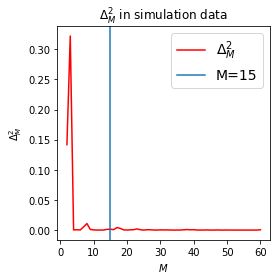

In [42]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.plot(np.linspace(2, len(delta_m)+1, len(delta_m)), delta_m, '-', c = 'red')
ax.axvline(x=15)
ax.legend((r'$\Delta_{M}^{2}$', 'M=15'), prop = {'size' : 14})

ax.set(xlabel=r'$M$', ylabel=r'$\Delta_{M}^{2}$',title=r'$\Delta_{M}^{2}$' + ' in simulation data')
fig.tight_layout()
plt.show()

### 4.3 Estimate interaction effect as well as its uncertainty

In [43]:
def imuncertainty(mlp, data, num_cluster, n_iter = 200):

    kmeans = KMeans(n_clusters=num_cluster, random_state=0).fit(data)
    data_sep = []
    for i in range(num_cluster):
        data_i = data[(kmeans.labels_ == i).tolist()]; data_i = torch.tensor(data_i, dtype=torch.float)
        data_sep.append(data_i) 

    print('############# The 1st interation for uncertainty calculation')
    # Initialize the first interaction
    Hessian = MC_GEH_cluster(mlp, data_sep, num_cluster)
    int_unc = matrix2vec(Hessian)

    # Rest of Interaction
    for num_int in range(n_iter - 1):
        if ((num_int + 2) % 10 == 0):
            print('############# The %dth interation for uncertainty calculation' %(num_int + 2))
        Hessian = MC_GEH_cluster(mlp, data_sep, num_cluster)
        int_unc_new = matrix2vec(Hessian)
    
        int_unc = np.concatenate((int_unc, int_unc_new), axis=1)

    mean_interaction = np.mean(int_unc, axis = 1)
    std_interaction = np.std(int_unc, axis = 1)
    print('mean of each interaction is')
    print(mean_interaction)
    print('std of each interaction is')
    print(std_interaction)
    
    return mean_interaction, std_interaction

In [44]:
num_cluster = 15
mean_interaction, std_interaction = imuncertainty(mlp, x_test.numpy(), num_cluster)

############# The 1st interation for uncertainty calculation
############# The 10th interation for uncertainty calculation
############# The 20th interation for uncertainty calculation
############# The 30th interation for uncertainty calculation
############# The 40th interation for uncertainty calculation
############# The 50th interation for uncertainty calculation
############# The 60th interation for uncertainty calculation
############# The 70th interation for uncertainty calculation
############# The 80th interation for uncertainty calculation
############# The 90th interation for uncertainty calculation
############# The 100th interation for uncertainty calculation
############# The 110th interation for uncertainty calculation
############# The 120th interation for uncertainty calculation
############# The 130th interation for uncertainty calculation
############# The 140th interation for uncertainty calculation
############# The 150th interation for uncertainty calculation
###

In [45]:
IS, Sorted_IS = vec2dic(mean_interaction, num_feature)
print(Sorted_IS)

[('Interaction: 3 4 ', 1.1276185688058544), ('Interaction: 3 5 ', 0.7738534631569487), ('Interaction: 1 3 ', 0.7279694476150499), ('Interaction: 2 3 ', 0.3285089157595713), ('Interaction: 4 5 ', 0.3142240000624243), ('Interaction: 1 4 ', 0.29055816967552917), ('Interaction: 1 5 ', 0.22547909396032442), ('Interaction: 1 2 ', 0.15344964767064517), ('Interaction: 3 8 ', 0.13808443643023552), ('Interaction: 2 4 ', 0.13764551229916144), ('Interaction: 3 6 ', 0.13411447704662968), ('Interaction: 2 5 ', 0.10809637768809566), ('Interaction: 4 6 ', 0.09669903455395094), ('Interaction: 4 8 ', 0.09471876884376122), ('Interaction: 1 6 ', 0.09100937483287436), ('Interaction: 6 8 ', 0.07654364620662787), ('Interaction: 1 8 ', 0.07545745086640929), ('Interaction: 2 8 ', 0.06257289598163941), ('Interaction: 2 6 ', 0.05908322224017471), ('Interaction: 5 8 ', 0.05650796306277628), ('Interaction: 3 7 ', 0.05141140880252742), ('Interaction: 1 7 ', 0.0443668955066896), ('Interaction: 5 6 ', 0.0418158443213